In [1]:
from beamformer import CURRENT_POINTING_MAP, NoSuchPointingError
from sps_common import constants
import pickle
import json
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import astropy.coordinates as c
import ast

import pandas as pd
import numpy as np
from IPython.display import Image, display
import matplotlib.pyplot as plt
import math
from matplotlib.ticker import MaxNLocator
from psrqpy import QueryATNF
import pandas as pd


from sps_databases import db_utils
from sps_databases.db_api import get_nearby_known_sources, delete_known_source
from sps_common.interfaces import MultiPointingCandidate
from sps_databases.db_api import get_pointing
from sps_databases.models import Pointing, KnownSource

In [2]:
db_host = 'sps-archiver'
db_port = 27017
db_name = 'test'
db = db_utils.connect(host=db_host, port=db_port, name=db_name)
ks_collection = get_nearby_known_sources(0, 0, np.infty)

ks_in_stack = []
for ks in ks_collection:
    if ks.pos_dec_deg < 52 and ks.pos_dec_deg > 46:
        ks_in_stack.append(ks)

print(f'{len(ks_in_stack)} sources in stack')

# Remove milli-second pulsars
print('Removing ms pulsars')
remove_idx = []
for i,ks in enumerate(ks_in_stack):
    if 1 / ks.spin_period_s >= 100 and np.isnan(ks.spin_period_s) == False:
        print(f'\t Removing {ks.source_name}')
        remove_idx.append(i)

ks_in_stack = np.array(ks_in_stack)
ks_in_stack = np.delete(ks_in_stack, remove_idx)

print(f'{len(ks_in_stack)} sources remain')

# Remove pulsars with no known P or DM, later we can try test values to see what the S_min could be
print('Removing pulsars with no known P or DM')
remove_idx = []
for i,ks in enumerate(ks_in_stack):
    if np.isnan(ks.spin_period_s) == True or np.isnan(ks.dm) == True:
        print(f'\t Removing {ks.source_name}')
        remove_idx.append(i)

ks_in_stack = np.array(ks_in_stack)
ks_in_stack = np.delete(ks_in_stack, remove_idx)

print(f'{len(ks_in_stack)} sources remain')

for ks in ks_in_stack:
    ks.survey = ast.literal_eval(ks.survey)

# Remove duplicate pulsars
remove_idx = []
for i, pulsar1 in enumerate(ks_in_stack):
    for j, pulsar2 in enumerate(ks_in_stack):
        if i != j: 
            if np.abs(pulsar1.dm - pulsar2.dm) < 1:
                if np.abs(pulsar1.spin_period_s - pulsar2.spin_period_s) < 1:
                    if np.abs(pulsar1.pos_dec_deg - pulsar2.pos_dec_deg) < 1:
                        if np.abs(pulsar1.pos_ra_deg - pulsar2.pos_ra_deg) < 1:
                            print(f'{pulsar1.source_name} and {pulsar2.source_name} are duplicates')
                            if pulsar1.survey[-1] != 'psr_scraper': 
                                remove_idx.append(j)
                                # print(pulsar1.survey)
                                print(f'Removing {pulsar2.source_name}')
                            else:
                                remove_idx.append(i)
                                # print(pulsar2.survey)
                                print(f'Removing {pulsar1.source_name}')

ks_in_stack = np.delete(ks_in_stack, remove_idx)
print(f'{len(ks_in_stack)} sources remain')


103 sources in stack
Removing ms pulsars
	 Removing J0102+4839
	 Removing J0506+50
	 Removing J0636+5128
	 Removing J0645+5158
	 Removing J0653+4706
	 Removing J1544+4937
	 Removing J1710+4923
	 Removing J2051+50
	 Removing J2215+5135
	 Removing J0329+50
	 Removing J0636+51
	 Removing J1710+49
	 Removing J0645+51
	 Removing J0652+47
89 sources remain
Removing pulsars with no known P or DM
	 Removing J1957+5033
	 Removing J2111+4606
	 Removing J2139+4716
	 Removing J0835+49
	 Removing J2100+50
	 Removing J2155+47
	 Removing J2300+50
82 sources remain
J0058+4950 and J0058+49 are duplicates
Removing J0058+49
J0402+4825 and J0402+4827 are duplicates
Removing J0402+4827
J0518+5125 and J0518+51 are duplicates
Removing J0518+51
J1502+4653 and J1502+4654 are duplicates
Removing J1502+4654
J1541+47 and J1541+4703 are duplicates
Removing J1541+47
J1800+5034 and J1800+50 are duplicates
Removing J1800+50
J1838+50 and J1838+5051 are duplicates
Removing J1838+5051
J1951+4724 and J1949+4722 are dupli

In [3]:
%%capture output

# Fold ks

import subprocess

psr_names = []
for ks in ks_in_stack:
    psr_names.append(ks.source_name)

for psr_name in psr_names:
    # result = subprocess.run(["python3", "/home/magnuslargent/packages/champss_software/champss/folding/multiday_search/multidayfold_pipeline.py", "--psr", f'{psr_name}', "--docker-password", "P3nt1ct0n"]) 
    # result = subprocess.run(["P3nt1ct0n"]) 
    # print(result.stdout)
    # print(result.stderr)
    print(psr_name)
    process = subprocess.Popen(["python3","/home/magnuslargent/champss_software/champss/folding/multiday_search/multidayfold_pipeline.py", "--psr", f'{psr_name}', "--docker-password", "P3nt1ct0n", "--use-workflow", "--docker-image-name", "chimefrb/champss_software:known_source_db_fix", "--db-name", "test"], 
                           stdin=subprocess.PIPE, 
                           stdout=subprocess.PIPE, 
                           stderr=subprocess.PIPE, 
                           text=True)

# Send input to the subprocess
    stdout, stderr = process.communicate(input='P3nt1ct0n')
    print(stdout)
# Print the output from the subprocess
print('Output:', stdout)
print('Error:', stderr)

KeyboardInterrupt: 

In [15]:
# Grab folded sigma

import os.path
from champss.folding import multiday_search
from beamformer.utilities.common import find_closest_pointing, get_data_list

for ks in ks_in_stack: 
    ra = ks.pos_ra_deg
    dec = ks.pos_dec_deg
    cand_str = f'/data/chime/sps/archives/candidates/{round(ra, 2)}_{round(dec, 2)}/explore_grid.npz'
    if os.path.isfile(cand_str):
        z = np.load(cand_str)
        if z.files[-1] == 'nobs':
            ks.nobs = z['nobs']
            ks.SNR_det = z['SN']
        else:
            ks.nobs = 30
            ks.SNR_det = float('nan')


    else:
        ks.nobs = 30
        ks.SNR_det = float('nan')
    print(ks.source_name, ks.SNR_det, ks.nobs)


B0011+47 nan 30
B0052+51 16.763416 10
B0053+47 39.406704 10
J0058+4950 39.494724 10
J0106+4855 4.3244777 10
J0402+4825 23.640396 10
J0426+4933 104.19328 10
B0458+46 255.19379 2
J0518+5125 4.259433 10
J0815+4611 57.108723 10
B1112+50 27.367195 10
J1502+4653 nan 30
J1518+4904 15.748017 10
J1715+46 4.9630365 10
J1759+5036 6.8116264 10
J1800+5034 42.88612 10
J1836+51 4.380711 10
J1838+50 4.072615 10
J1951+4724 nan 30
B1953+50 568.912 10
B2021+51 nan 30
B2022+50 153.47684 10
J2024+48 4.0887904 10
J2044+4614 50.714508 10
J2047+5029 68.135284 9
J2048+4951 13.249373 9
J2053+4650 nan 30
J2053+4718 nan 30
J2057+4701 nan 30
B2111+46 nan 30
J2138+4911 210.41988 10
J2139+4738g 4.402696 10
J2203+50 4.002941 10
J2208+4610 nan 30
B2217+47 1527.8954 10
B2303+46 nan 30
J2329+4743 nan 30
J2338+4818 5.015158 9
J0215+51 5.175414 10
J2119+49 58.173283 10
J2208+46 nan 30
J2338+4824 4.9971843 9
J2301+4809 4.9653277 10
J2300+4824 3.4320347 10
J0427+4723 5.196036 2
J2053+4721 nan 30
J1802+4721 8.057429 10
J2002

In [4]:
#Calculate SNR from S_600 / S_min

# First calculate S_600

params = [
    #"NAME",
    # "S30",
    "S40",
    "S50", 
    "S60", 
    "S80",
    "S100",
    "S150",
    "S200", 
    "S300",
    "S350",
    "S400",
    "S600", 
    "S700", 
    "S800",
    "S900",
    "S1400",
    "S1600",
    "S2000",
    "S3000",
    "S4000",
    "S6000",
    "S8000",
    # "S10G",
    # "S20G",
    # "S50G", 
    "S100G",
    "S150G",
    "SPINDX",
    "W50"
    ]

sigmas = []
for ks in ks_in_stack:
    psr_name = ks.source_name
    if ks.survey[-1] != 'psr_scraper':  # Check if published 
        query = QueryATNF(params=params, psrs=psr_name, include_errs=False)
        df = query.table.to_pandas()
        S600 = df['S600'][0]
        W50 = df['W50'][0]
        if np.isnan(W50) == False:
            ks.W50 = W50
        else:
            ks.W50 = 0
        if np.isnan(S600) == False:
                ks.S_600 = S600
        else:
            print('No S600 value in ATNF, checking for spectral index')
            spectral_idx = df['SPINDX'][0]
            if np.isnan(spectral_idx) == True:
                print('No spectral idx, assume = -1.8')
                spectral_idx = -1.8
            freqs = []
            for freq in df.columns:  
                if np.isnan(df[freq][0]) == False and freq != 'SPINDX':
                    freqs.append(int(freq[1::]))
            if len(freqs) > 0: 
                freqs = np.array(freqs)
                f_diff = np.abs(freqs - 600)
                idx = np.argmin(f_diff)
                S_x = df['S' + str(freqs[idx])][0]
                # print(S_x)
                # print(freqs[idx])
                S_600 = S_x * (600 / freqs[idx]) ** (spectral_idx)
                ks.S_600 = S_600
            else: 
                print('No fluxes to calculate from, needs manual calc')
                ks.S_600 = float('nan')
    else:
        print(f'Not published: {ks.source_name, ks.survey}')
        ks.S_600 = float('nan')


No S600 value in ATNF, checking for spectral index
No spectral idx, assume = -1.8
No S600 value in ATNF, checking for spectral index
No spectral idx, assume = -1.8
No S600 value in ATNF, checking for spectral index
No spectral idx, assume = -1.8
No S600 value in ATNF, checking for spectral index
No spectral idx, assume = -1.8
No S600 value in ATNF, checking for spectral index
No spectral idx, assume = -1.8
No S600 value in ATNF, checking for spectral index
No spectral idx, assume = -1.8
No S600 value in ATNF, checking for spectral index
No spectral idx, assume = -1.8
No S600 value in ATNF, checking for spectral index
No spectral idx, assume = -1.8
No S600 value in ATNF, checking for spectral index
No spectral idx, assume = -1.8
No S600 value in ATNF, checking for spectral index
No spectral idx, assume = -1.8
No S600 value in ATNF, checking for spectral index
No spectral idx, assume = -1.8
No S600 value in ATNF, checking for spectral index
No spectral idx, assume = -1.8
No S600 value in

In [5]:
from mwprop.ne2001p.NE2001 import ne2001

# Constants
bandwidth = [400, 800] # MHz, CHIME
freq_ref = (bandwidth[1] + bandwidth[0]) / 2
SEFD = 90 # Jy, CHIME
G = 1.16 # K/Jy, CHIME
T_sys = SEFD * G
t_samp = 0.983 # ms, CHIME
n_channels = [1024, 2048, 4096, 8192, 16384]

# Assumptions
beta = 1.20
SNR_min = 7
n_p = 2
duty_cycle = 0.04

def get_tau(ra, dec, dm, freq_ref):
    sky_coords = c.SkyCoord(ra * u.deg, dec * u.deg, frame='icrs')
    # dist, tau_sc_1GHz = pygedm.dm_to_dist(sky_coords.galactic.l, sky_coords.galactic.b, dm, method='ne2001')
    # tau_sc_1GHz = pyne2001.get_dist_full(sky_coords.galactic.l, sky_coords.galactic.b, dm)
    gl = sky_coords.galactic.l
    gl = gl.to(u.deg).value
    gb = sky_coords.galactic.b
    gb = gb.to(u.deg).value
    Dk,Dv,Du,Dd = ne2001(ldeg=gl,bdeg=gb,dmd=dm,ndir=1,classic=False, do_analysis = False, dmd_only=False)
    tau_sc_1GHz = Dv['TAU'] # ms
    tau_sc = tau_sc_1GHz * (freq_ref/1000)**(-4) # MHz
    return tau_sc

def eq_smearing_dt(dm, f_1, freq_res):
    return 4.15 * 10**6 * (f_1**-2 - (f_1 + freq_res)**-2) * dm # in ms

def S_min(SNR_min, T_sys, G, n_p, t_int, delta_f, W, P):
    # print(f'SNR_min: {SNR_min}')
    # print(f'Tsys: {T_sys}')
    # print(f't_int: {t_int}')
    # print(f'delta_f: {delta_f}')
    # print(f'W: {W}')
    # print(f'P: {P}')
    return beta * (SNR_min * T_sys) / (G * np.sqrt(n_p * t_int * delta_f)) * np.sqrt(W / (P - W))

def find_nearest_ptg(ra, dec):
    dist = []
    pointings = list(db.pointings.find())
    for pointing in pointings:
            ptg_ra = pointing['ra']
            ptg_dec = pointing['dec']
            dist.append(((ra - ptg_ra)**2 + (dec - ptg_dec)**2)**0.5)
            
    nearest_idx = dist.index(min(dist))
    nearest_ptg = pointings[nearest_idx]
    return nearest_ptg

def S_min_pulsar(ra, dec, P, dm, W=0, n_obs=30):

    pointing = find_nearest_ptg(ra,dec)
    
    length = pointing['length']
    beam = pointing['beam_row']
    nchans = pointing['nchans']
    t_int = pointing['length'] * t_samp * n_obs

    # Scattering timescale
    freq_ref = (bandwidth[1] + bandwidth[0]) / 2
    tau_sc = get_tau(ra, dec, dm, freq_ref)

    # Effective sampling interval
    tau_samp = 1.5 * t_samp 

    # Frequency resolution
    freq_res = (bandwidth[1] - bandwidth[0]) / np.array(nchans)

    # Smearing
    smearing_dt = eq_smearing_dt(
        dm, 
        (bandwidth[1] + bandwidth[0]) / 2, 
        freq_res
    )
    
    # print(f'smearing_dt: {smearing_dt}')
    # print(f'tau_sc: {tau_sc}')
    # print(f'tau_samp: {tau_samp}')

    if W==0: 

        # Width
        duty_cycle = 0.05
        width = np.sqrt(
            smearing_dt**2 
            +
            (P * duty_cycle)**2 
            +
            (tau_sc)**2
            +
            (tau_samp)**2 
        ) 
    else:
        width = np.sqrt(
            smearing_dt**2 
            +
            (W)**2 
            +
            (tau_sc)**2
            +
            (tau_samp)**2 
        ) 

    # S_min
    S_min_psr = S_min(
        SNR_min, 
        T_sys, 
        G, 
        n_p, 
        t_int, 
        (bandwidth[1] - bandwidth[0]), 
        width, 
        P
    )
    return S_min_psr


In [57]:
for ks in ks_in_stack:
    ra = ks.pos_ra_deg
    dec = ks.pos_dec_deg
    P = 1000*ks.spin_period_s # ms
    dm = ks.dm
    if hasattr(ks, 'W50') == True:
        W = ks.W50
    n_obs = ks.nobs 
    if hasattr(ks, 'S_min') == False:
        ks.S_min = S_min_pulsar(ra, dec, P, dm, W, n_obs) * 1000 # mJy
    #Calculate SNR from S_600 / S_min
    # if hasattr(ks, 'S600') == True:
    ks.SNR_calc = 7 * ks.S_600 / ks.S_min 
    print(ks.source_name, ks.S_min, ks.SNR_calc)
   

B0011+47 1.8036998010065852 34.92820699145267
B0052+51 2.056543837722694 9.530552979460913
B0053+47 1.8098664949647627 5.801532891631562
J0058+4950 1.201039596229486 4.197053879835432
J0106+4855 2.674818208526684 0.09621703498322606
J0402+4825 1.9810616842375863 nan
J0426+4933 1.4021756337944136 2.6489507808549058
B0458+46 3.3021805006612475 18.654340666012917
J0518+5125 2.1078719565862185 0.9193175504762203
J0815+4611 1.5843269237317954 5.323888849140494
B1112+50 1.134955449085124 23.437043296670357
J1502+4653 0.8448901620328747 nan
J1518+4904 2.587858236163703 23.532973773045416
J1715+46 1.6412325889685098 nan
J1759+5036 1.0695842556899937 1.2082740536570942
J1800+5034 1.2692487004040187 62.467612640186545
J1836+51 1.830839482159636 0.5796395238716391
J1838+50 0.7770183640090188 nan
J1951+4724 3.907084034558042 nan
B1953+50 1.1943331811463478 82.05415502727422
B2021+51 0.7894758138584772 851.1977038481687
B2022+50 1.091317381620944 25.657064087453033
J2024+48 2.583126055700316 nan
J2

In [58]:
SNR_dets = []
SNR_calcs = []
S600s = []
pulsars = []
for ks in ks_in_stack:
    if hasattr(ks, 'SNR_det')==False:
        ks.SNR_det = float('nan') 
        print(f'{ks.source_name} has no SNR from folded cand')
    if np.isnan(ks.SNR_det) == False and np.isnan(ks.SNR_calc) == False:
        SNR_dets.append(ks.SNR_det)
        SNR_calcs.append(ks.SNR_calc)
        S600s.append(ks.S_600)
        pulsars.append(ks.source_name)
        # print('All good', f'{ks.source_name}, SNR detected: {ks.SNR_det}, SNR predicted {ks.SNR_calc}, S_600: {ks.S_600}, S_min: {ks.S_min}')
    if np.isnan(ks.SNR_det) == True and np.isnan(ks.SNR_calc) == False:
        SNR_dets.append(0)
        SNR_calcs.append(ks.SNR_calc)
        S600s.append(ks.S_600)
        pulsars.append(ks.source_name)
        print('Could not fold', f'{ks.source_name}, {ks.survey}, SNR detected: {ks.SNR_det}, SNR predicted {ks.SNR_calc}, S_600: {ks.S_600}, S_min: {ks.S_min}')
    if np.isnan(ks.SNR_det) == False and np.isnan(ks.SNR_calc) == True:
        SNR_dets.append(ks.SNR_det)
        SNR_calcs.append(0)
        S600s.append(ks.S_600)
        pulsars.append(ks.source_name)
        print('Could not calc SNR', f'{ks.source_name}, {ks.survey}, SNR detected: {ks.SNR_det}, SNR predicted {ks.SNR_calc}, S_600: {ks.S_600}, S_min: {ks.S_min}')





SNR_calcs = np.array(SNR_calcs)

Could not fold B0011+47, ['gb1', 'gb2', 'gb3', 'lotaas'], SNR detected: nan, SNR predicted 34.92820699145267, S_600: 9.0, S_min: 1.8036998010065852
Could not calc SNR J0402+4825, ['fast_crafts', 'fast_gpps'], SNR detected: 23.640396118164062, SNR predicted nan, S_600: nan, S_min: 1.9810616842375863
Could not calc SNR J1715+46, ['lotaas', 'fast_gpps'], SNR detected: 4.96303653717041, SNR predicted nan, S_600: nan, S_min: 1.6412325889685098
Could not calc SNR J1838+50, ['chime'], SNR detected: 4.072615146636963, SNR predicted nan, S_600: nan, S_min: 0.7770183640090188
Could not fold B2021+51, ['jb1', 'gb1', 'gb2', 'gb3', 'gb4', 'lotaas', 'fast_gpps'], SNR detected: nan, SNR predicted 851.1977038481687, S_600: 96.0, S_min: 0.7894758138584772
Could not calc SNR J2024+48, ['gbt350'], SNR detected: 4.088790416717529, SNR predicted nan, S_600: nan, S_min: 2.583126055700316
Could not calc SNR J2044+4614, ['misc', 'gbncc', 'fast_gpps'], SNR detected: 50.714508056640625, SNR predicted nan, S_600

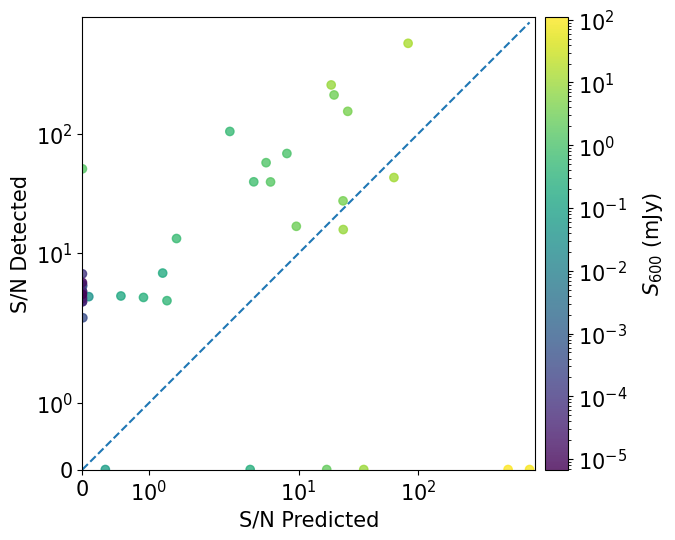

In [59]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm

cm = plt.colormaps.get_cmap('viridis')
fig, ax = plt.subplots(figsize=(7, 7))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
ax.set_aspect('equal')
sc = ax.scatter(SNR_calcs, SNR_dets, c=S600s, alpha=0.8, cmap=cm, norm=LogNorm())
cbar = fig.colorbar(sc, cax=cax)
cbar.set_label('$S_{600}$ (mJy)', labelpad=10)
ax.set_xlabel('S/N Predicted')
ax.set_ylabel('S/N Detected')
x = np.linspace(0, np.max(SNR_calcs), 1000)
ax.set_xlim(0, np.max(SNR_calcs) + 100)
ax.set_ylim(0, np.max(SNR_calcs) + 100)
ax.set_yscale('symlog')
ax.set_xscale('symlog')
ax.plot(x, x, '--')
plt.rcParams.update({'font.size': 15})
plt.tight_layout()
plt.show()

60


In [60]:
for ks in ks_in_stack:
    if "fast-gpps" in ks.survey or "fast_gpps" in ks.survey:
        if np.isnan(ks.S_600) == True:
            print(ks.source_name, ks.survey, ks.S_600, ks.nobs, ks.S_min, ks.SNR_det, ks.SNR_calc)

J0402+4825 ['fast_crafts', 'fast_gpps'] nan 10 1.9810616842375863 23.640396 nan
J1715+46 ['lotaas', 'fast_gpps'] nan 10 1.6412325889685098 4.9630365 nan
J2053+4650 ['htru_eff', 'fast_gpps'] nan 30 nan nan nan
J2053+4718 ['fast_crafts', 'fast_gpps'] nan 30 0.1799027861023871 nan nan
J2139+4738g ['fast_gpps'] nan 10 1.3764383999065035 4.402696 nan
J2208+4610 ['chime', 'fast_gpps'] nan 30 1.2293878452880687 nan nan


In [56]:
# Grab presto plots from http://zmtt.bao.ac.cn/GPPS/GPPSnewPSR.html

def S_600_manual(SNR, T_int, DC):
    # T_rec, G from https://arxiv.org/abs/2105.08460
    T_rec = 25 # K
    G = 16 # K / Jy
    SEFD = T_rec / G
    n_p = 2 
    bandwidth = 400 * 10**6 # Hz
    S_1400 = SNR * SEFD / np.sqrt(n_p * T_int * bandwidth) * np.sqrt(DC / (1 - DC)) # Jy
    S_600 = S_1400 * (600 / 1400) ** (-1.8)
    return S_600

# J2128+5051g, http://zmtt.bao.ac.cn/GPPS/images/gpps0450_J2128p5051g_20220828.png
print(S_600_manual(32.9, 900, 0.05))
[setattr(ks, 'S_600', S_600_manual(32.9, 900, 0.05)) for ks in ks_in_stack if ks.source_name == 'J2128+5051g']
# J2101+4636g, http://zmtt.bao.ac.cn/GPPS/images/gpps0453_J2101p4636g_20220902.png
print(S_600_manual(131.4, 900, 0.1))
[setattr(ks, 'S_600', S_600_manual(131.4, 900, 0.1)) for ks in ks_in_stack if ks.source_name == 'J2101+4636g']
# J2104+4644g, http://zmtt.bao.ac.cn/GPPS/images/gpps0462_J2104p4644g_20220905.png
print(S_600_manual(39.5, 900, 0.075))
[setattr(ks, 'S_600', S_600_manual(39.5, 900, 0.075)) for ks in ks_in_stack if ks.source_name == 'J2104+4644g']
# J0417+5058g, http://zmtt.bao.ac.cn/GPPS/images/gpps0540_J0417p5058g_20230106.png
print(S_600_manual(21.9, 900, 0.1))
[setattr(ks, 'S_600', S_600_manual(21.9, 900, 0.1)) for ks in ks_in_stack if ks.source_name == 'J0417+5058g']
# J2103+4620g, http://zmtt.bao.ac.cn/GPPS/images/gpps0628_J2103p4620g_20231017.png
print(S_600_manual(229.7, 900, 0.05))
[setattr(ks, 'S_600', S_600_manual(229.7, 900, 0.05)) for ks in ks_in_stack if ks.source_name == 'J2103+4620g']
# J2106+4602g, http://zmtt.bao.ac.cn/GPPS/images/gpps0630_J2106p4602g_20231017.png
print(S_600_manual(45.3, 900, 0.02))
[setattr(ks, 'S_600', S_600_manual(45.3, 900, 0.02)) for ks in ks_in_stack if ks.source_name == 'J2106+4602g']
# J0408+4955g, http://zmtt.bao.ac.cn/GPPS/images/gpps0638_J0408p4955g_20240124.png
print(S_600_manual(54.8, 700, 0.1))
[setattr(ks, 'S_600', S_600_manual(54.8, 700, 0.1)) for ks in ks_in_stack if ks.source_name == 'J0408+4955g']
# J2100+4712g, http://zmtt.bao.ac.cn/GPPS/images/gpps0642_J2100p4712g_20240125.png
print(S_600_manual(6.7, 900, 0.05))
[setattr(ks, 'S_600', S_600_manual(6.7, 900, 0.05)) for ks in ks_in_stack if ks.source_name == 'J2100+4712g']
# J0414+4859g, http://zmtt.bao.ac.cn/GPPS/images/gpps0643_J0414p4859g_20231205.png (confirmation plot seems wrong?)
print(S_600_manual(8.3, 250, 0.05))
[setattr(ks, 'S_600', S_600_manual(8.3, 250, 0.05)) for ks in ks_in_stack if ks.source_name == 'J0414+4859g']
# J2103+4602g, http://zmtt.bao.ac.cn/GPPS/images/gpps0650_J2103p4602g_20240314.png
print(S_600_manual(9, 900, 0.05))
[setattr(ks, 'S_600', S_600_manual(9, 900, 0.05)) for ks in ks_in_stack if ks.source_name == 'J2103+4602g']
# J2102+5046g, http://zmtt.bao.ac.cn/GPPS/images/gpps0718_J2102p5046g_20240905.png
print(S_600_manual(5.7, 90, 0.002))
[setattr(ks, 'S_600', S_600_manual(5.7, 90, 0.002)) for ks in ks_in_stack if ks.source_name == 'J2102+5046g']
# J2116+4906g, http://zmtt.bao.ac.cn/GPPS/images/gpps0451_J2116p4906g_20220829.png
print(S_600_manual(71.2, 900, 0.3))
[setattr(ks, 'S_600', S_600_manual(71.2, 900, 0.3)) for ks in ks_in_stack if ks.source_name == 'J2116+4906g']

6.387502583588684e-05
0.0003706688595562006
9.51850740894315e-05
6.177814325936678e-05
0.0004459602867630154
5.4766142654585414e-05
0.00017528450632277093
1.3007983984815861e-05
3.057486397789195e-05
1.747341132288698e-05
6.828677052577655e-06
0.00039446056489094003


[None]